## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided to help you work with Keras and TensorFlow. It accompanies the bonus chapters for my book. The code is in Python3, using the versions of libraries as of April 2021.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

### Slow Ahead!

If you're running without a GPU, this notebook can take a full day and night to run. Training these systems takes time!

## Bonus Chapter 3 - Notebook 3: CNNs

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization

import numpy as np

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
random_seed = 42
np.random.seed(random_seed)

In [5]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

In [6]:
# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [-1, 1]
X_train = np.interp(X_train, [0, 255], [-1,1])
X_test = np.interp(X_test, [0, 255], [-1,1])

# save original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape sample data to 4D tensor using channels_last convention 
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

In [7]:
# Make the different CNN models we use in this chapter

def make_simple_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5),
                     activation='relu', padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_bigger_cnn_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pooling_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                     kernel_constraint=MaxNorm(3))) 
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_striding_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     strides=(2, 2), kernel_constraint=MaxNorm(3),
                     input_shape=(image_height, image_width, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                     strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_striding_batchnorm_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation=None, padding='same',
                     strides=(2, 2), 
                     input_shape=(image_height, image_width, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pattern_1_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation=None, padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Conv2D(32, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(8, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pattern_2_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation=None, padding='same',
                     input_shape=(image_height, image_width, 1)))
    model.add(Conv2D(32, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(8, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

In [8]:
def run_model(model_maker, plot_title, filename):
    model = model_maker()
    np.random.seed(random_seed)
    history = model.fit(X_train, y_train, validation_split=0.25, 
                     epochs=100, batch_size=256)
    plot_accuracy_and_loss(history, plot_title, filename)
    return history

Epoch 1/100
235/235 [==============================] - 13s 54ms/step - loss: 0.2825 - accuracy: 0.9182 - val_loss: 0.1002 - val_accuracy: 0.9721
Epoch 2/100
235/235 [==============================] - 13s 53ms/step - loss: 0.0863 - accuracy: 0.9749 - val_loss: 0.0689 - val_accuracy: 0.9777
Epoch 3/100
235/235 [==============================] - 12s 52ms/step - loss: 0.0616 - accuracy: 0.9815 - val_loss: 0.0596 - val_accuracy: 0.9817
Epoch 4/100
235/235 [==============================] - 13s 56ms/step - loss: 0.0490 - accuracy: 0.9849 - val_loss: 0.0608 - val_accuracy: 0.9804
Epoch 5/100
235/235 [==============================] - 13s 55ms/step - loss: 0.0366 - accuracy: 0.9888 - val_loss: 0.0545 - val_accuracy: 0.9823
Epoch 6/100
235/235 [==============================] - 15s 64ms/step - loss: 0.0317 - accuracy: 0.9902 - val_loss: 0.0603 - val_accuracy: 0.9818
Epoch 7/100
235/235 [==============================] - 13s 54ms/step - loss: 0.0287 - accuracy: 0.9908 - val_loss: 0.0589 - val_ac

235/235 [==============================] - 12s 51ms/step - loss: 5.2265e-05 - accuracy: 1.0000 - val_loss: 0.0811 - val_accuracy: 0.9866
Epoch 57/100
235/235 [==============================] - 12s 53ms/step - loss: 4.6675e-05 - accuracy: 1.0000 - val_loss: 0.0825 - val_accuracy: 0.9865
Epoch 58/100
235/235 [==============================] - 12s 50ms/step - loss: 4.2220e-05 - accuracy: 1.0000 - val_loss: 0.0830 - val_accuracy: 0.9868
Epoch 59/100
235/235 [==============================] - 12s 49ms/step - loss: 3.8103e-05 - accuracy: 1.0000 - val_loss: 0.0846 - val_accuracy: 0.9867
Epoch 60/100
235/235 [==============================] - 11s 48ms/step - loss: 3.4292e-05 - accuracy: 1.0000 - val_loss: 0.0847 - val_accuracy: 0.9870
Epoch 61/100
235/235 [==============================] - 12s 53ms/step - loss: 3.0916e-05 - accuracy: 1.0000 - val_loss: 0.0854 - val_accuracy: 0.9863
Epoch 62/100
235/235 [==============================] - 13s 57ms/step - loss: 2.7422e-05 - accuracy: 1.0000 - val

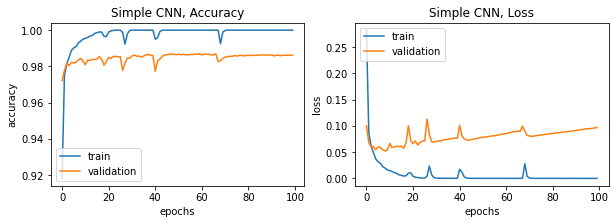

In [9]:
simple_history = run_model(
    make_simple_cnn_model, 'Simple CNN', 'Simple-CNN-graphs')

Epoch 1/100
235/235 [==============================] - 40s 168ms/step - loss: 0.3817 - accuracy: 0.8859 - val_loss: 0.1162 - val_accuracy: 0.9659
Epoch 2/100
235/235 [==============================] - 39s 166ms/step - loss: 0.1225 - accuracy: 0.9636 - val_loss: 0.0801 - val_accuracy: 0.9745
Epoch 3/100
235/235 [==============================] - 42s 177ms/step - loss: 0.0890 - accuracy: 0.9730 - val_loss: 0.0600 - val_accuracy: 0.9815
Epoch 4/100
235/235 [==============================] - 42s 177ms/step - loss: 0.0738 - accuracy: 0.9777 - val_loss: 0.0498 - val_accuracy: 0.9834
Epoch 5/100
235/235 [==============================] - 48s 203ms/step - loss: 0.0656 - accuracy: 0.9801 - val_loss: 0.0466 - val_accuracy: 0.9849
Epoch 6/100
235/235 [==============================] - 40s 171ms/step - loss: 0.0548 - accuracy: 0.9833 - val_loss: 0.0431 - val_accuracy: 0.9861
Epoch 7/100
235/235 [==============================] - 41s 176ms/step - loss: 0.0529 - accuracy: 0.9835 - val_loss: 0.0464 -

Epoch 57/100
235/235 [==============================] - 38s 163ms/step - loss: 0.0135 - accuracy: 0.9952 - val_loss: 0.0401 - val_accuracy: 0.9890
Epoch 58/100
235/235 [==============================] - 37s 157ms/step - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.0454 - val_accuracy: 0.9894
Epoch 59/100
235/235 [==============================] - 39s 167ms/step - loss: 0.0121 - accuracy: 0.9960 - val_loss: 0.0424 - val_accuracy: 0.9894
Epoch 60/100
235/235 [==============================] - 37s 157ms/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.0436 - val_accuracy: 0.9899
Epoch 61/100
235/235 [==============================] - 36s 152ms/step - loss: 0.0132 - accuracy: 0.9953 - val_loss: 0.0473 - val_accuracy: 0.9882
Epoch 62/100
235/235 [==============================] - 36s 153ms/step - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.0438 - val_accuracy: 0.9887
Epoch 63/100
235/235 [==============================] - 39s 167ms/step - loss: 0.0122 - accuracy: 0.9957 - val_loss: 0

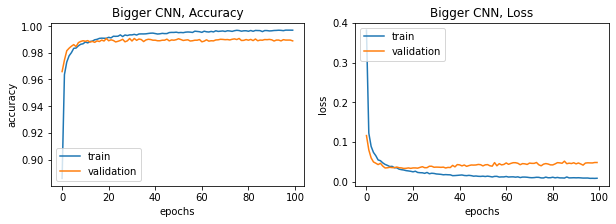

In [10]:
bigger_history = run_model(
    make_bigger_cnn_model, 'Bigger CNN', 'Bigger-CNN-graphs')

Epoch 1/100
235/235 [==============================] - 33s 137ms/step - loss: 0.3533 - accuracy: 0.8971 - val_loss: 0.1003 - val_accuracy: 0.9745
Epoch 2/100
235/235 [==============================] - 35s 151ms/step - loss: 0.0800 - accuracy: 0.9753 - val_loss: 0.0597 - val_accuracy: 0.9836
Epoch 3/100
235/235 [==============================] - 35s 148ms/step - loss: 0.0580 - accuracy: 0.9823 - val_loss: 0.0456 - val_accuracy: 0.9878
Epoch 4/100
235/235 [==============================] - 34s 144ms/step - loss: 0.0467 - accuracy: 0.9855 - val_loss: 0.0453 - val_accuracy: 0.9878
Epoch 5/100
235/235 [==============================] - 38s 161ms/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.0367 - val_accuracy: 0.9892
Epoch 6/100
235/235 [==============================] - 31s 130ms/step - loss: 0.0342 - accuracy: 0.9886 - val_loss: 0.0390 - val_accuracy: 0.9891
Epoch 7/100
235/235 [==============================] - 29s 123ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 0.0339 -

Epoch 57/100
235/235 [==============================] - 27s 116ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.0373 - val_accuracy: 0.9911
Epoch 58/100
235/235 [==============================] - 27s 117ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0407 - val_accuracy: 0.9895
Epoch 59/100
235/235 [==============================] - 27s 116ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0331 - val_accuracy: 0.9913
Epoch 60/100
235/235 [==============================] - 28s 120ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0442 - val_accuracy: 0.9891
Epoch 61/100
235/235 [==============================] - 30s 127ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.0342 - val_accuracy: 0.9912
Epoch 62/100
235/235 [==============================] - 28s 120ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.0348 - val_accuracy: 0.9901
Epoch 63/100
235/235 [==============================] - 29s 123ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0

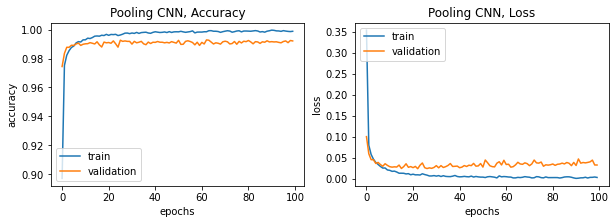

In [11]:
pooling_history = run_model(
    make_pooling_cnn_model, 'Pooling CNN', 'Pooling-CNN-graphs')

Epoch 1/100
235/235 [==============================] - 10s 40ms/step - loss: 0.4653 - accuracy: 0.8580 - val_loss: 0.1128 - val_accuracy: 0.9667
Epoch 2/100
235/235 [==============================] - 9s 38ms/step - loss: 0.1300 - accuracy: 0.9604 - val_loss: 0.0627 - val_accuracy: 0.9795
Epoch 3/100
235/235 [==============================] - 9s 39ms/step - loss: 0.0939 - accuracy: 0.9713 - val_loss: 0.0633 - val_accuracy: 0.9784
Epoch 4/100
235/235 [==============================] - 9s 38ms/step - loss: 0.0759 - accuracy: 0.9769 - val_loss: 0.0432 - val_accuracy: 0.9863
Epoch 5/100
235/235 [==============================] - 9s 38ms/step - loss: 0.0660 - accuracy: 0.9794 - val_loss: 0.0385 - val_accuracy: 0.9876
Epoch 6/100
235/235 [==============================] - 9s 40ms/step - loss: 0.0562 - accuracy: 0.9815 - val_loss: 0.0366 - val_accuracy: 0.9886
Epoch 7/100
235/235 [==============================] - 9s 40ms/step - loss: 0.0522 - accuracy: 0.9839 - val_loss: 0.0322 - val_accuracy

235/235 [==============================] - 10s 42ms/step - loss: 0.0099 - accuracy: 0.9965 - val_loss: 0.0297 - val_accuracy: 0.9927
Epoch 58/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0091 - accuracy: 0.9969 - val_loss: 0.0273 - val_accuracy: 0.9923
Epoch 59/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0097 - accuracy: 0.9968 - val_loss: 0.0341 - val_accuracy: 0.9916
Epoch 60/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0086 - accuracy: 0.9968 - val_loss: 0.0280 - val_accuracy: 0.9920
Epoch 61/100
235/235 [==============================] - 10s 42ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0340 - val_accuracy: 0.9909
Epoch 62/100
235/235 [==============================] - 10s 41ms/step - loss: 0.0094 - accuracy: 0.9967 - val_loss: 0.0283 - val_accuracy: 0.9925
Epoch 63/100
235/235 [==============================] - 9s 40ms/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 0.0318 - val_accuracy:

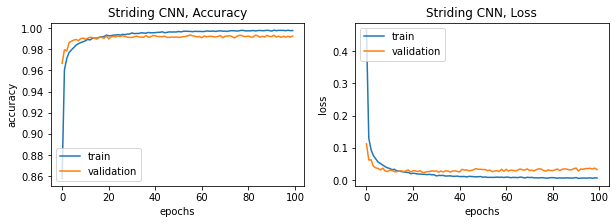

In [12]:
striding_history = run_model(
    make_striding_cnn_model, 'Striding CNN', 'Striding-CNN-graphs')

Epoch 1/100
235/235 [==============================] - 11s 45ms/step - loss: 0.2738 - accuracy: 0.9167 - val_loss: 0.2176 - val_accuracy: 0.9549
Epoch 2/100
235/235 [==============================] - 11s 47ms/step - loss: 0.0671 - accuracy: 0.9797 - val_loss: 0.0760 - val_accuracy: 0.9757
Epoch 3/100
235/235 [==============================] - 11s 45ms/step - loss: 0.0473 - accuracy: 0.9857 - val_loss: 0.0459 - val_accuracy: 0.9841
Epoch 4/100
235/235 [==============================] - 11s 47ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.0408 - val_accuracy: 0.9860
Epoch 5/100
235/235 [==============================] - 11s 46ms/step - loss: 0.0267 - accuracy: 0.9919 - val_loss: 0.0398 - val_accuracy: 0.9872
Epoch 6/100
235/235 [==============================] - 11s 47ms/step - loss: 0.0209 - accuracy: 0.9935 - val_loss: 0.0389 - val_accuracy: 0.9868
Epoch 7/100
235/235 [==============================] - 11s 48ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0447 - val_ac

235/235 [==============================] - 10s 45ms/step - loss: 2.1568e-06 - accuracy: 1.0000 - val_loss: 0.0509 - val_accuracy: 0.9915
Epoch 57/100
235/235 [==============================] - 10s 44ms/step - loss: 1.9605e-06 - accuracy: 1.0000 - val_loss: 0.0513 - val_accuracy: 0.9916
Epoch 58/100
235/235 [==============================] - 11s 47ms/step - loss: 1.9722e-06 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9917
Epoch 59/100
235/235 [==============================] - 12s 52ms/step - loss: 1.5547e-06 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9917
Epoch 60/100
235/235 [==============================] - 11s 46ms/step - loss: 1.4336e-06 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9917
Epoch 61/100
235/235 [==============================] - 11s 47ms/step - loss: 1.2586e-06 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9917
Epoch 62/100
235/235 [==============================] - 11s 48ms/step - loss: 1.1214e-06 - accuracy: 1.0000 - val

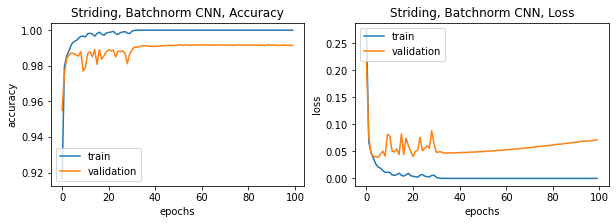

In [13]:
striding_batchnorm_history = run_model(
        make_striding_batchnorm_cnn_model, 
        'Striding, Batchnorm CNN', 'Striding-Batchnorm-CNN-graphs')

Epoch 1/100
235/235 [==============================] - 73s 307ms/step - loss: 0.2572 - accuracy: 0.9189 - val_loss: 0.0730 - val_accuracy: 0.9747
Epoch 2/100
235/235 [==============================] - 75s 319ms/step - loss: 0.0691 - accuracy: 0.9779 - val_loss: 0.0617 - val_accuracy: 0.9789
Epoch 3/100
235/235 [==============================] - 74s 313ms/step - loss: 0.0490 - accuracy: 0.9843 - val_loss: 0.0473 - val_accuracy: 0.9846
Epoch 4/100
235/235 [==============================] - 71s 303ms/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.0459 - val_accuracy: 0.9851
Epoch 5/100
235/235 [==============================] - 71s 304ms/step - loss: 0.0274 - accuracy: 0.9915 - val_loss: 0.0382 - val_accuracy: 0.9879
Epoch 6/100
235/235 [==============================] - 73s 312ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0459 - val_accuracy: 0.9857
Epoch 7/100
235/235 [==============================] - 72s 307ms/step - loss: 0.0222 - accuracy: 0.9928 - val_loss: 0.0310 -

Epoch 57/100
235/235 [==============================] - 69s 292ms/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.0430 - val_accuracy: 0.9921
Epoch 58/100
235/235 [==============================] - 69s 293ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0466 - val_accuracy: 0.9929
Epoch 59/100
235/235 [==============================] - 69s 295ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0569 - val_accuracy: 0.9901
Epoch 60/100
235/235 [==============================] - 69s 294ms/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.0835 - val_accuracy: 0.9850
Epoch 61/100
235/235 [==============================] - 70s 299ms/step - loss: 0.0104 - accuracy: 0.9975 - val_loss: 0.0522 - val_accuracy: 0.9908
Epoch 62/100
235/235 [==============================] - 69s 295ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0580 - val_accuracy: 0.9914
Epoch 63/100
235/235 [==============================] - 77s 327ms/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0

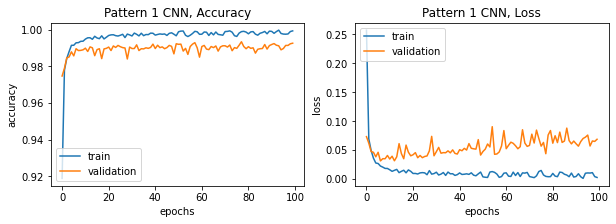

In [14]:
pattern_1_history = run_model(
        make_pattern_1_cnn_model, 'Pattern 1 CNN', 'Pattern-1-CNN-graphs')

Epoch 1/100
235/235 [==============================] - 37s 157ms/step - loss: 0.2663 - accuracy: 0.9195 - val_loss: 0.1254 - val_accuracy: 0.9579
Epoch 2/100
235/235 [==============================] - 37s 157ms/step - loss: 0.0969 - accuracy: 0.9699 - val_loss: 0.0957 - val_accuracy: 0.9696
Epoch 3/100
235/235 [==============================] - 38s 163ms/step - loss: 0.0708 - accuracy: 0.9776 - val_loss: 0.0785 - val_accuracy: 0.9754
Epoch 4/100
235/235 [==============================] - 40s 172ms/step - loss: 0.0596 - accuracy: 0.9805 - val_loss: 0.0748 - val_accuracy: 0.9766
Epoch 5/100
235/235 [==============================] - 40s 171ms/step - loss: 0.0484 - accuracy: 0.9842 - val_loss: 0.0703 - val_accuracy: 0.9791
Epoch 6/100
235/235 [==============================] - 39s 166ms/step - loss: 0.0413 - accuracy: 0.9864 - val_loss: 0.0785 - val_accuracy: 0.9769
Epoch 7/100
235/235 [==============================] - 38s 164ms/step - loss: 0.0345 - accuracy: 0.9886 - val_loss: 0.0903 -

Epoch 57/100
235/235 [==============================] - 44s 187ms/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.0918 - val_accuracy: 0.9845
Epoch 58/100
235/235 [==============================] - 39s 168ms/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.1005 - val_accuracy: 0.9811
Epoch 59/100
235/235 [==============================] - 42s 180ms/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 0.1023 - val_accuracy: 0.9831
Epoch 60/100
235/235 [==============================] - 39s 166ms/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.1013 - val_accuracy: 0.9822
Epoch 61/100
235/235 [==============================] - 39s 166ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0984 - val_accuracy: 0.9838
Epoch 62/100
235/235 [==============================] - 39s 167ms/step - loss: 0.0058 - accuracy: 0.9986 - val_loss: 0.1077 - val_accuracy: 0.9806
Epoch 63/100
235/235 [==============================] - 40s 170ms/step - loss: 0.0085 - accuracy: 0.9972 - val_loss: 0

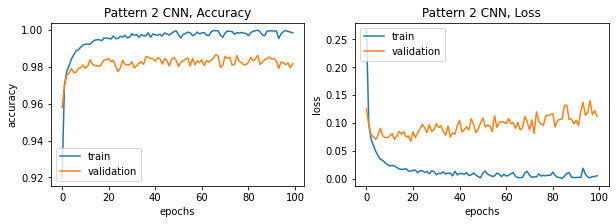

In [15]:
pattern_2_history = run_model(
        make_pattern_2_cnn_model, 'Pattern 2 CNN', 'Pattern-2-CNN-graphs')

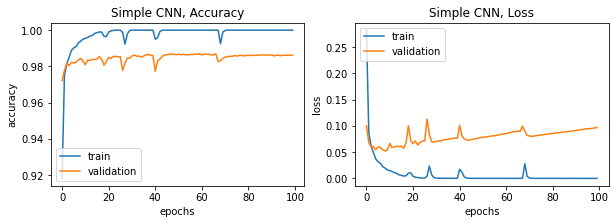

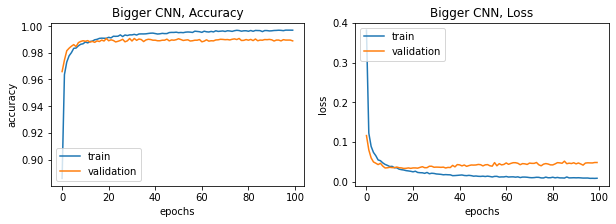

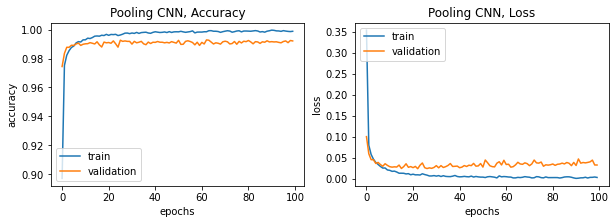

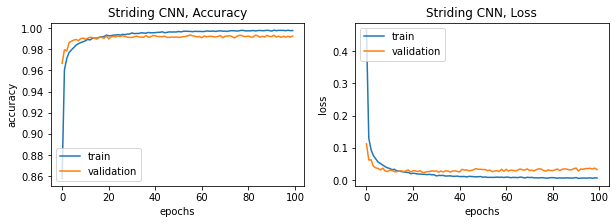

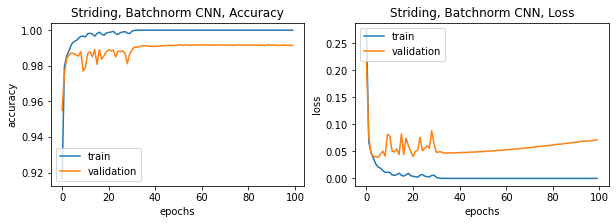

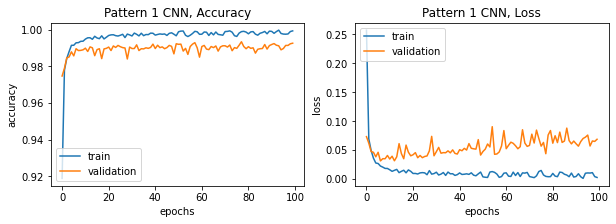

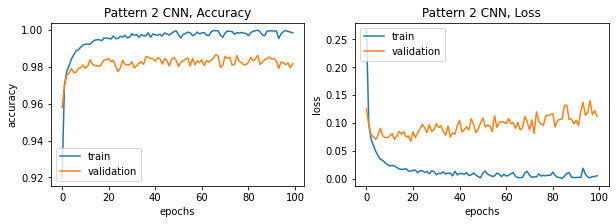

In [16]:
# get the plots by themselves
plot_accuracy_and_loss(simple_history, 'Simple CNN', 'Simple-CNN-graphs')
plot_accuracy_and_loss(bigger_history, 'Bigger CNN', 'Bigger-CNN-graphs')
plot_accuracy_and_loss(pooling_history, 'Pooling CNN', 'Pooling-CNN-graphs')
plot_accuracy_and_loss(striding_history, 'Striding CNN', 'Striding-CNN-graphs')
plot_accuracy_and_loss(striding_batchnorm_history, 'Striding, Batchnorm CNN', 'Striding-Batchnorm-CNN-graphs')
plot_accuracy_and_loss(pattern_1_history, 'Pattern 1 CNN', 'Pattern-1-CNN-graphs')
plot_accuracy_and_loss(pattern_2_history, 'Pattern 2 CNN', 'Pattern-2-CNN-graphs')